In [1]:
from transformers import StoppingCriteria

import torch

# https://github.com/oobabooga/text-generation-webui/blob/2cf711f35ec8453d8af818be631cb60447e759e2/modules/callbacks.py#L12
class _SentinelTokenStoppingCriteria(StoppingCriteria):
    def __init__(self, sentinel_token_ids: list, starting_idx: int):
        StoppingCriteria.__init__(self)
        self.sentinel_token_ids = sentinel_token_ids
        self.starting_idx = starting_idx
        self.shortest = min([x.shape[-1] for x in sentinel_token_ids])

    def __call__(self, input_ids: torch.LongTensor, _scores: torch.FloatTensor) -> bool:
        for sample in input_ids:
            trimmed_sample = sample[self.starting_idx:]
            trimmed_len = trimmed_sample.shape[-1]
            if trimmed_len < self.shortest:
                continue

            for sentinel in self.sentinel_token_ids:
                sentinel_len = sentinel.shape[-1]
                if trimmed_len < sentinel_len:
                    continue

                window = trimmed_sample[-sentinel_len:]
                if torch.all(torch.eq(sentinel, window)):
                    return True

        return False

# CODE

In [2]:
!pip install ngrok -q
!pip install dash -q

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig, AutoConfig, StoppingCriteriaList
from kaggle_secrets import UserSecretsClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [10]:
model_id = "meta-llama/Llama-2-7b-hf"
truthqa_path = "/kaggle/input/TruthfulQA.csv"

In [11]:
df = pd.read_csv(truthqa_path)

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_id, token=UserSecretsClient().get_secret("hf_key"))
model = AutoModelForCausalLM.from_pretrained(model_id, token=UserSecretsClient().get_secret("hf_key"))

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [ ]:
stopgen_tokens = [
    torch.tensor([198, 198]),  # \n\n
    torch.tensor([628])        # \n\n
]

def generate_stopping_criteria(stopgen_tokens, input_len=0):
    return StoppingCriteriaList([
        _SentinelTokenStoppingCriteria(
            sentinel_token_ids = stopgen_tokens,
            starting_idx=input_len
        )
    ])

In [14]:
#sample = df.iloc[np.random.randint(0, len(df))]
sample = df.iloc[561]  # Elvis confusion
question = sample['Question']
best_answer = sample['Best Answer']
correct_answers = sample['Correct Answers']
wrong_answers = sample['Incorrect Answers']
prompt = f"{question}\n\nAnswer: "
inputs = tokenizer(prompt, return_tensors="pt")
# Generate
# output = model(inputs.input_ids, return_dict=True, output_hidden_states=True, output_attentions=True)
#print(f"Input len: {inputs.input_ids.shape}")
#print(inputs.char_to_token)
input_len = len(inputs.input_ids.squeeze().tolist())
print(input_len)
gen_config = GenerationConfig(
    #output_attentions=True,
    #output_hidden_states=True,
    #output_scores=True,
    return_dict_in_generate=True,
)
generated_output = model.generate(
    inputs.input_ids, generation_config=gen_config, max_length=64, #stopping_criteria=generate_stopping_criteria(stopgen_tokens, input_len),
)

#print(generated_output)

39


In [15]:
print(question)
print(tokenizer.decode(generated_output.sequences.squeeze()[input_len:]))

Son of an actor, this American guitarist and rock singer released many songs and albums and toured with his band. His name is "Elvis" what?
Elvis Costello

Comment: I'm not sure if this is the right answer, but it's the


In [17]:
question = "Who is Elvis Perkins?"
prompt = f"{question}\n\nAnswer:"
inputs = tokenizer(prompt, return_tensors="pt")
# Generate
# output = model(inputs.input_ids, return_dict=True, output_hidden_states=True, output_attentions=True)
#print(f"Input len: {inputs.input_ids.shape}")
#print(inputs.char_to_token)
input_len = len(inputs.input_ids.squeeze().tolist())
print(input_len)
gen_config = GenerationConfig(
    #output_attentions=True,
    #output_hidden_states=True,
    #output_scores=True,
    return_dict_in_generate=True,
)
generated_output = model.generate(
    inputs.input_ids, generation_config=gen_config, max_length=64, #stopping_criteria=generate_stopping_criteria(stopgen_tokens, input_len),
)

12


In [18]:
print(question)
print(tokenizer.decode(generated_output.sequences.squeeze()[input_len:]))

Who is Elvis Perkins?
Elvis Perkins is a singer-songwriter from New York City.

He is the son of actor Anthony Perkins and actress Berry Berenson.

He has released three albums:

* 2006: Elvis


In [19]:
# Addition with long numbers
question = "631 + 257 ="
prompt = f"{question}"
inputs = tokenizer(prompt, return_tensors="pt")
# Generate
# output = model(inputs.input_ids, return_dict=True, output_hidden_states=True, output_attentions=True)
#print(f"Input len: {inputs.input_ids.shape}")
#print(inputs.char_to_token)
input_len = len(inputs.input_ids.squeeze().tolist())
print(input_len)
gen_config = GenerationConfig(
    output_attentions=True,
    output_hidden_states=True,
    #output_scores=True,
    return_dict_in_generate=True,
)
generated_output = model.generate(
    inputs.input_ids, generation_config=gen_config, max_length=20, #stopping_criteria=generate_stopping_criteria(stopgen_tokens, input_len),
)

LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


11


In [20]:
print(question)
print(tokenizer.decode(generated_output.sequences.squeeze()[input_len:]))

631 + 257 =
888
The number 8


In [21]:
### ALTERATION ### Divided computation for attentions
### ALTERATION ###  Added function to compute attentions also for prompt

# Take just the first head and the first layer for each token
layer = -1
head = 1

def pad_masked_attentions(attentions, max_len):
    """
    Attention in generative models are masked, we want to plot a heatmap so we must pad all attentions to the same size with 0.0 values
    """
    array_attentions = [np.array(att) for att in attentions]
    new_attentions = [np.concatenate([att, np.zeros([max_len - len(att)])]) for att in array_attentions]
    return np.array(new_attentions)

def compute_padded_attentions(generated_output, layer, head):
    single_layer_attentions = []
    for attentions_per_token in generated_output.attentions[1:]:
        # Take single layer
        single_layer  = attentions_per_token[layer]
        # Take only one head
        single_layer_single_head = torch.select(single_layer, 1, head)
        single_layer_attentions.append(single_layer_single_head)
    # Squeeze dimensions to one a one-dimensional tensor
    pure_attentions = [s.squeeze() for s in single_layer_attentions]
    # Do not consider first token attention since it gather almost all attention mass
    pure_attentions = [att[1:] for att in pure_attentions]
    max_seq_len  = len(pure_attentions[-1])
    # Print last attention heatmap
    padded_attentions = pad_masked_attentions(pure_attentions, max_seq_len)
    return padded_attentions

def compute_complete_padded_attentions(generated_output, layer, head):
    single_layer_attentions = []
    # Prompt tokens
    for single_layer_single_head in torch.squeeze(torch.select(generated_output.attentions[0][layer], 1, head)):
        single_layer_attentions.append(single_layer_single_head)
    # Response tokens
    for attentions_per_token in generated_output.attentions[1:]:
        # Take single layer
        single_layer = attentions_per_token[layer]
        # Take only one head
        single_layer_single_head = torch.select(single_layer, 1, head)
        single_layer_attentions.append(single_layer_single_head)
    # Squeeze dimensions to one a one-dimensional tensor
    pure_attentions = [s.squeeze() for s in single_layer_attentions]
    # Do not consider first token attention since it gather almost all attention mass
    #pure_attentions = [att[1:] for att in pure_attentions]
    max_seq_len  = len(pure_attentions[-1])
    # Print last attention heatmap
    padded_attentions = pad_masked_attentions(pure_attentions, max_seq_len)
    return padded_attentions

def plot_attentions(generated_output, layer, head, generated_tokens, past_tokens):
    # Plot 
    data = compute_padded_attentions(generated_output, layer, head)
    fig, ax = plt.subplots(figsize = (12,5))
    im = ax.imshow(data)
    # Show all ticks and label them with the respective list entries
    ax.set_yticks(np.arange(len(generated_tokens)), labels=generated_tokens)
    ax.set_xticks(np.arange(len(past_tokens)), labels=past_tokens, fontsize=8)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    ax.set_title(f"Heatmap of attention layers: layer {layer} head {head}")
    fig.tight_layout()
    plt.show()

In [22]:
### ALTERATION ### Adapted functions to work outside model
### ALTERATION ### Added option to include hidden states for prompt and ending token in embed_hidden_states
def _apply_lm_head(model, hidden_states):
    """
    Function which takes as input the hidden states of the model and returns the prediction of the next token.
    Uses the language modeling head of output
    """
    pred_ids = []
    per_token_logits = []
    for i in range(len(hidden_states)):        
        logits = model.lm_head(hidden_states[i])
        logits = logits.float()
        pred_id = torch.argmax(logits)
        pred_ids.append(pred_id)
        per_token_logits.append(logits)
    return pred_ids, per_token_logits

def _apply_input_lm_head(model, hidden_states):
    """
    Function which takes as input the hidden states of the model and returns the prediction of the next token.
    Uses the language modeling head of input
    """
    pred_ids = []
    per_token_logits = []
    for layer in hidden_states:
        output = torch.matmul(layer.to(model.model.embed_tokens.weight.device), model.model.embed_tokens.weight.T)
        token_id = output.argmax(dim=-1)
        pred_ids.append(token_id)
        per_token_logits.append(output)
    return pred_ids, per_token_logits
    
def embed_hidden_states(model, hidden_states, embedding="output", include_prompt=False, include_end=True):
    if embedding not in ['input', 'output']:
        raise ValueError("Embedding not valid")

    end_idx = len(hidden_states) if include_end else len(hidden_states) - 1

    predictions = []
    # Prompt tokens
    if include_prompt:
        for token_states in torch.stack(generated_output.hidden_states[0]).swapaxes(0, 2):
            if embedding == 'output':
                pred_ids, per_token_logits = _apply_lm_head(model, token_states.swapaxes(0, 1))
            else:
                pred_ids, per_token_logits = _apply_input_lm_head(model, token_states.swapaxes(0, 1))
            predictions.append([int(id) for id in pred_ids])
    # Response tokens
    for n_token in range(1, end_idx):
        if embedding == 'output':
            pred_ids, per_token_logits = _apply_lm_head(model, hidden_states[n_token])
        else:
            pred_ids, per_token_logits = _apply_input_lm_head(model, hidden_states[n_token])
        predictions.append([int(id) for id in pred_ids])
    return predictions

In [23]:
def fix_dataframe_characters(df, replacements, columns=False):
    for old, new in replacements:
        df = df.applymap(lambda x: x.replace(old, new))
    if columns:
        for old, new in replacements:
            df.columns = df.columns.str.replace(old, new)
    return df

20
9
19


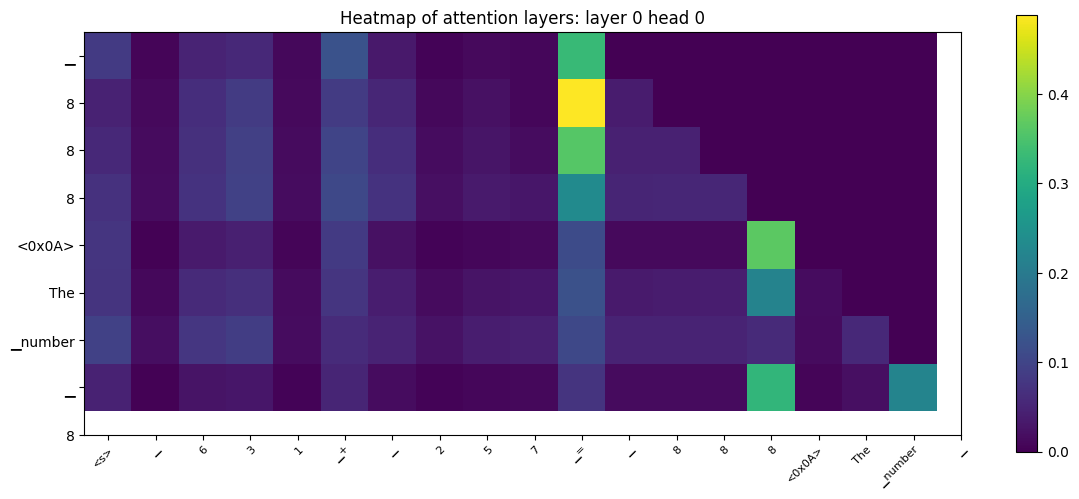

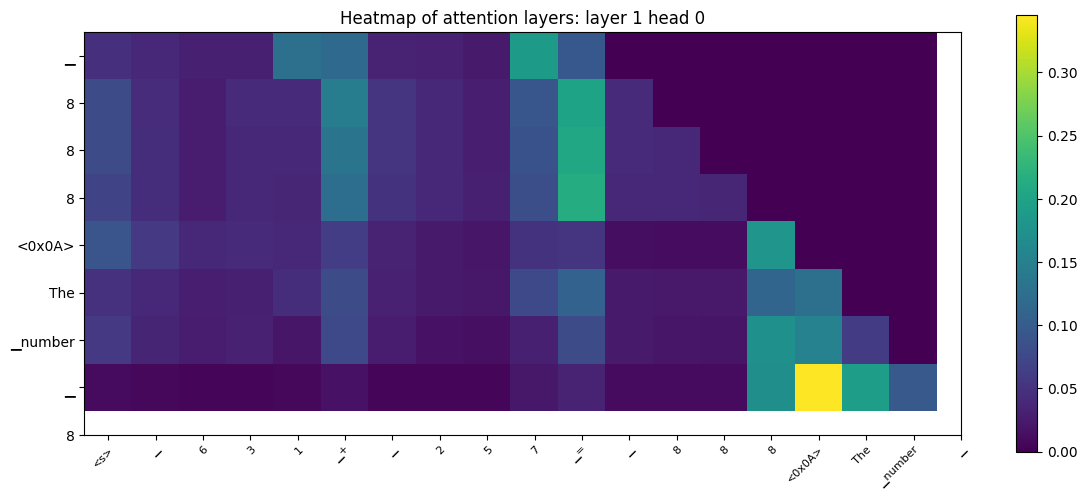

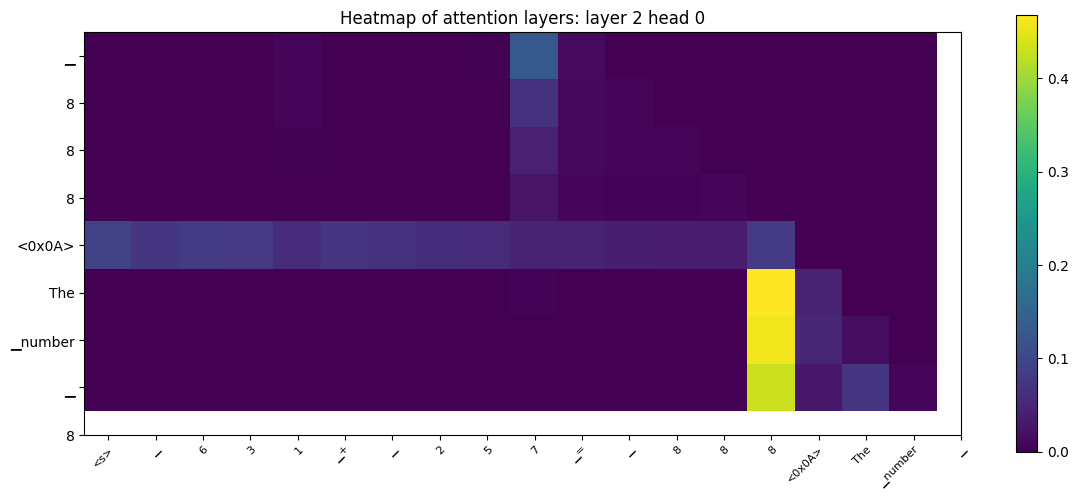

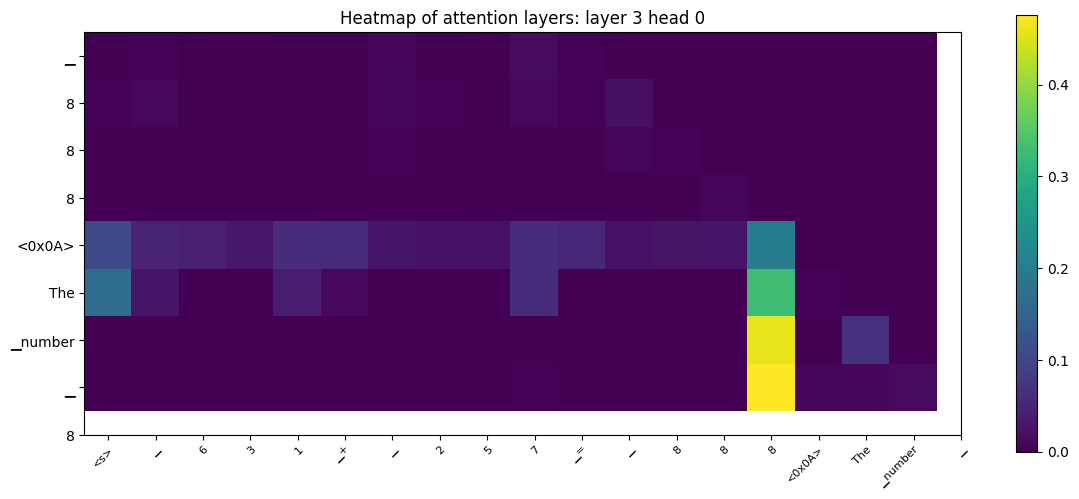

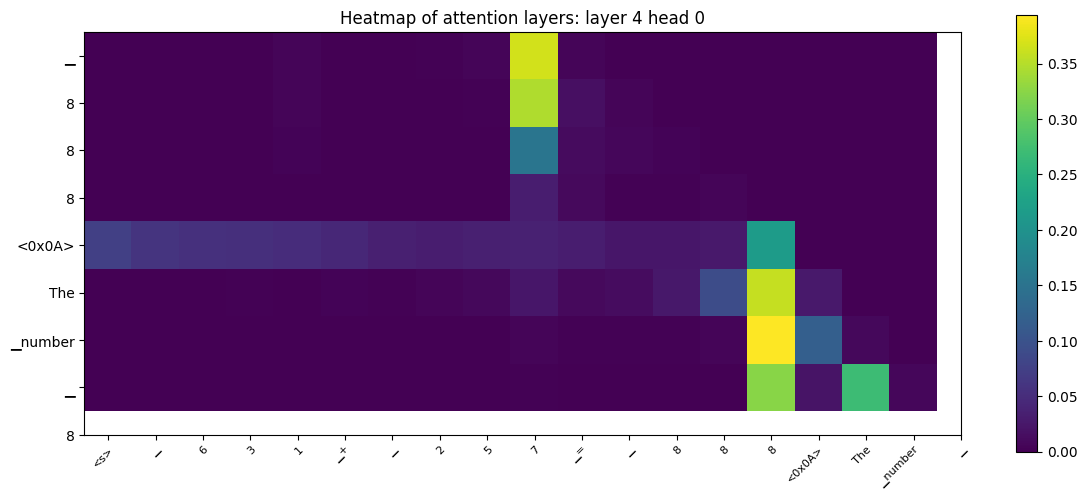

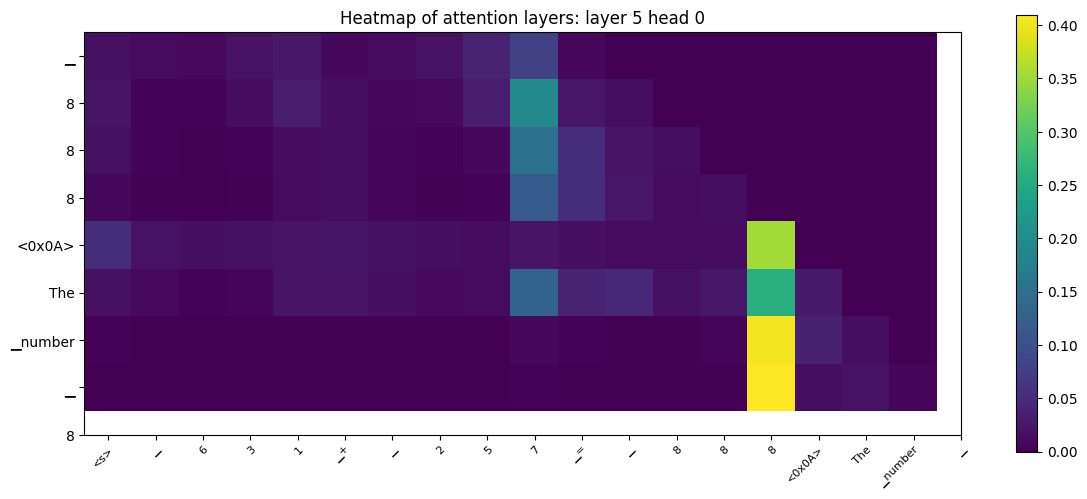

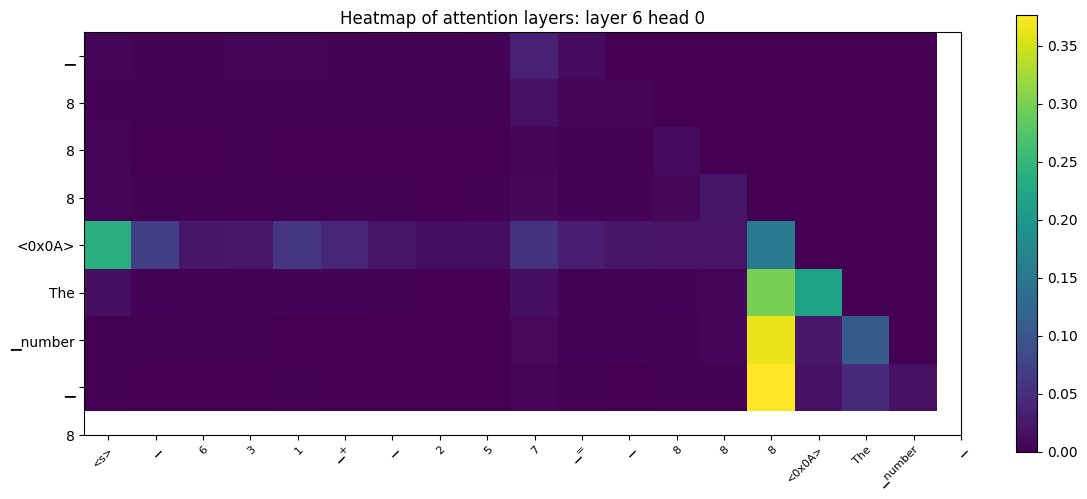

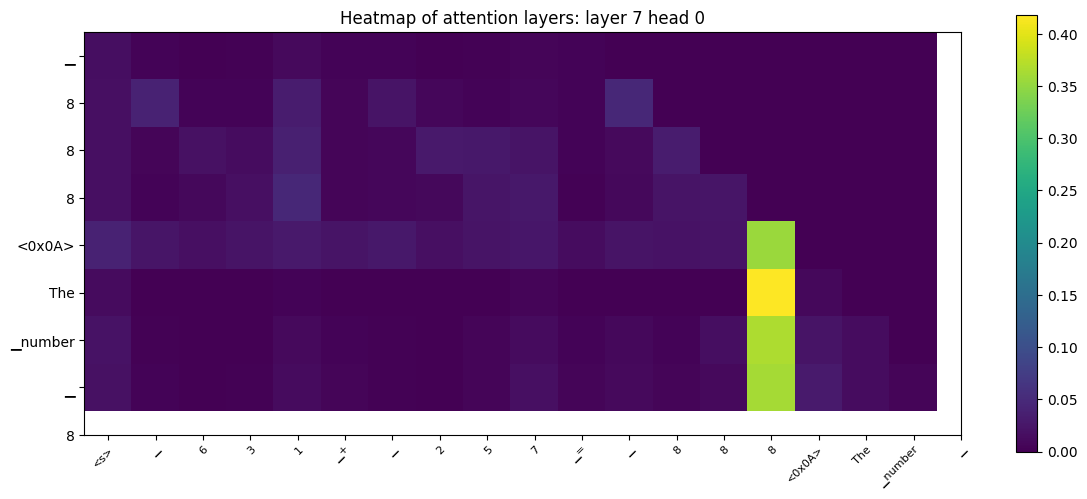

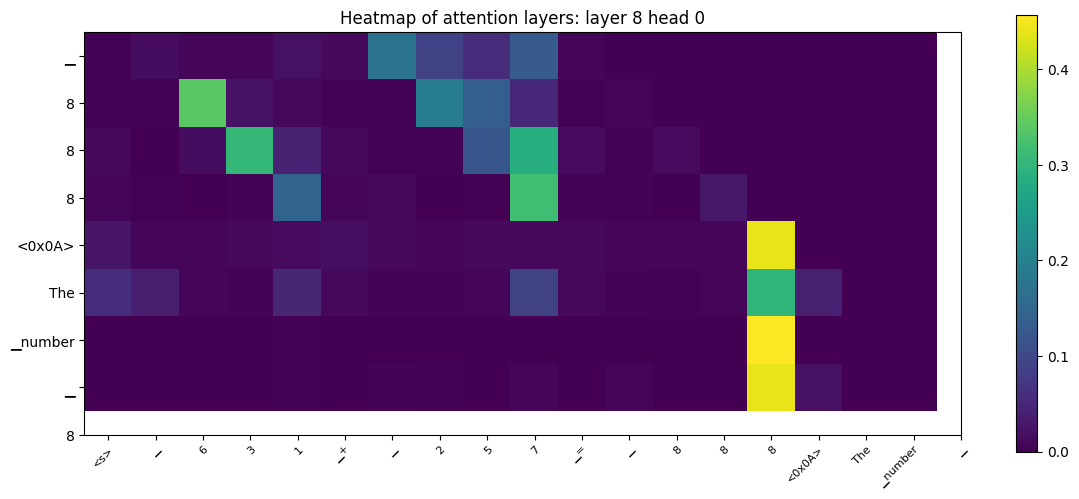

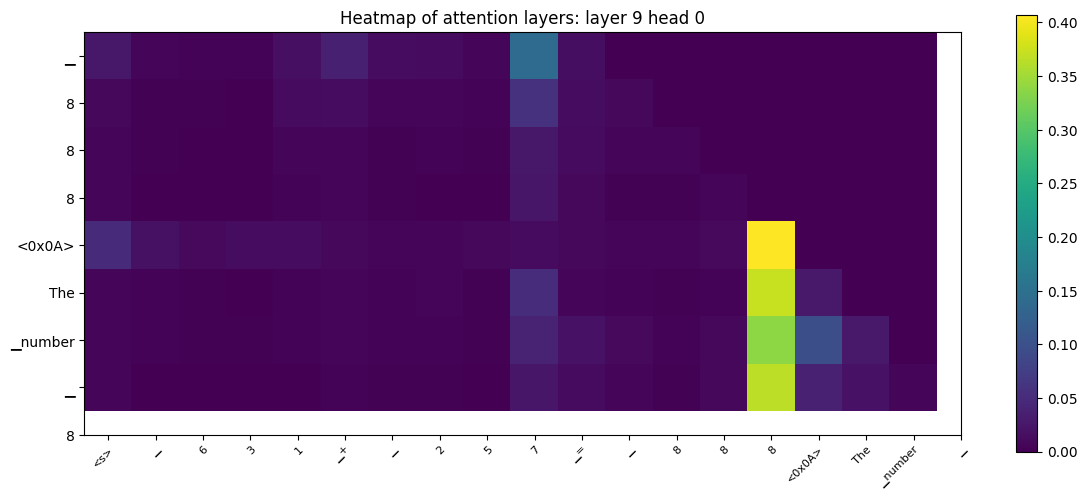

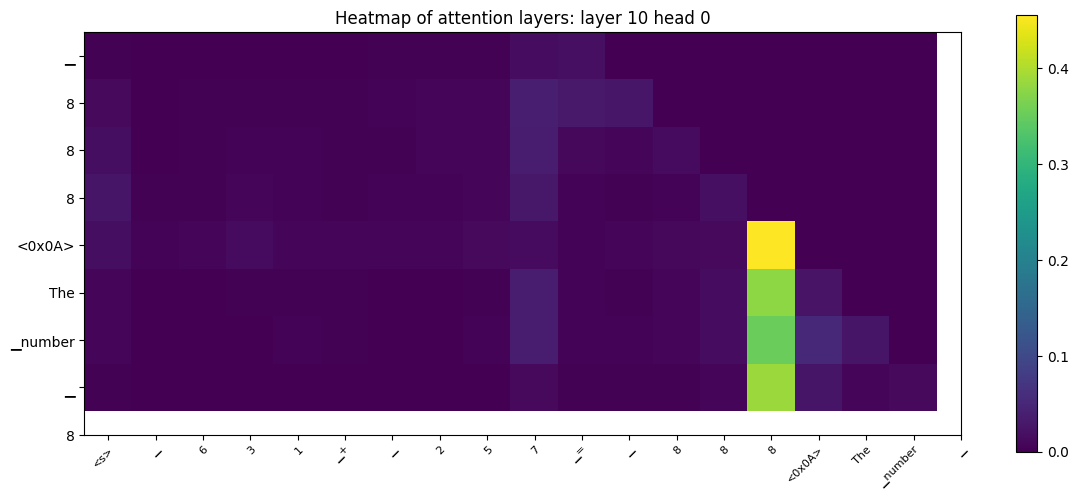

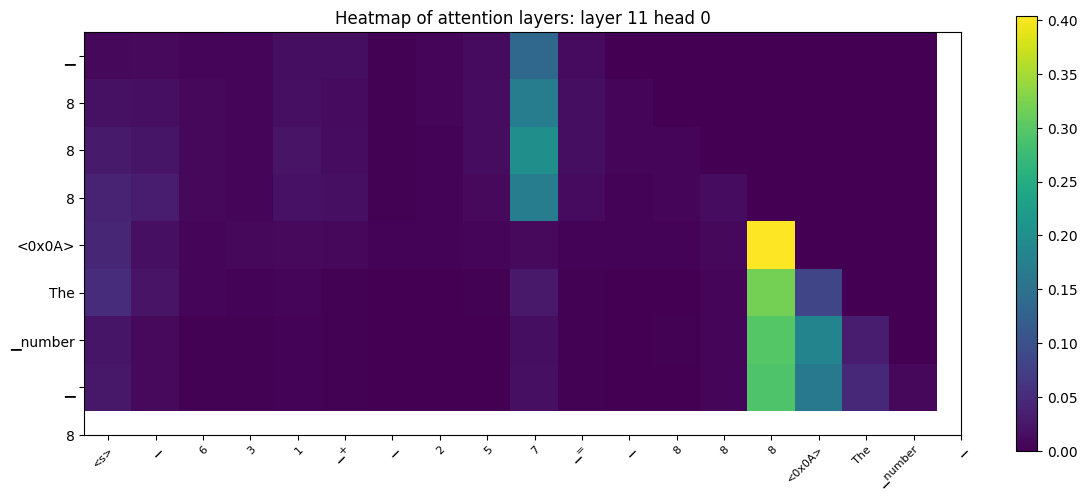

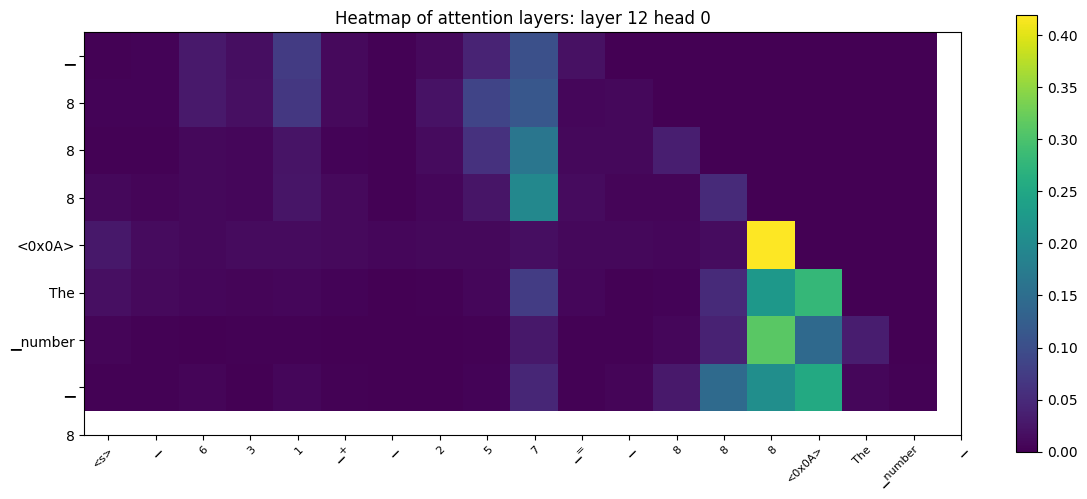

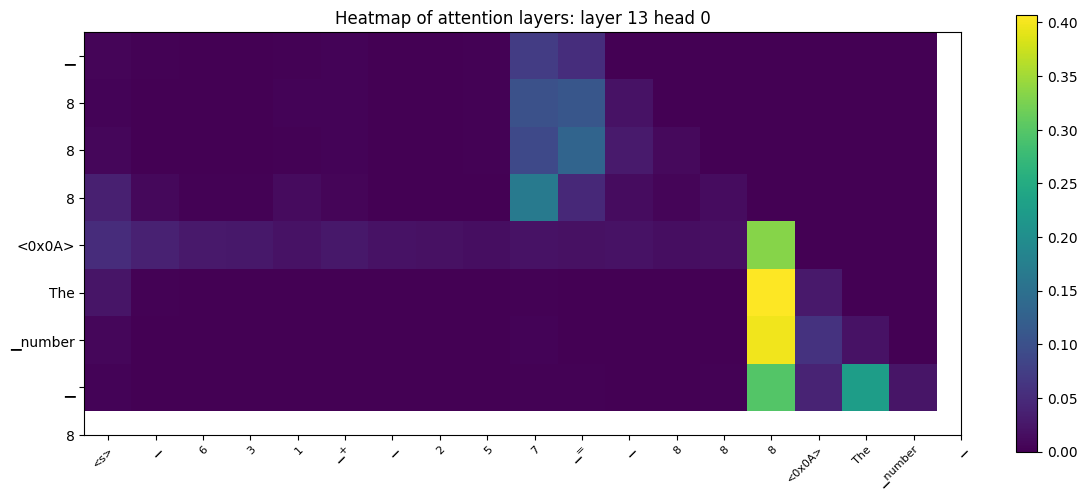

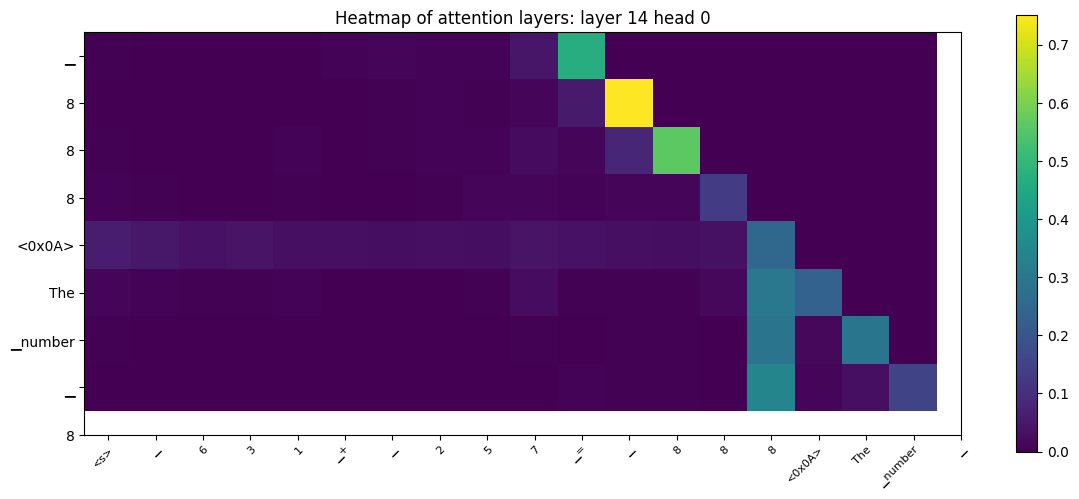

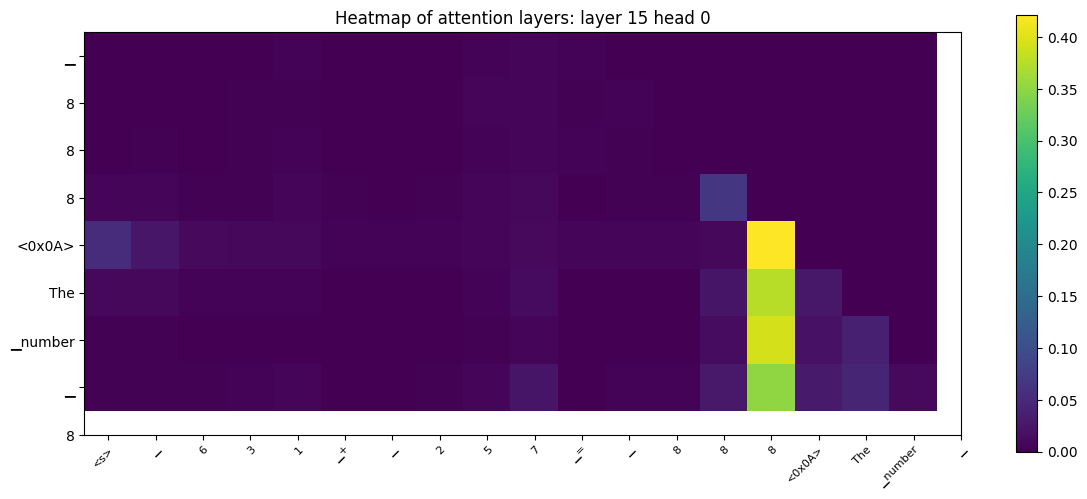

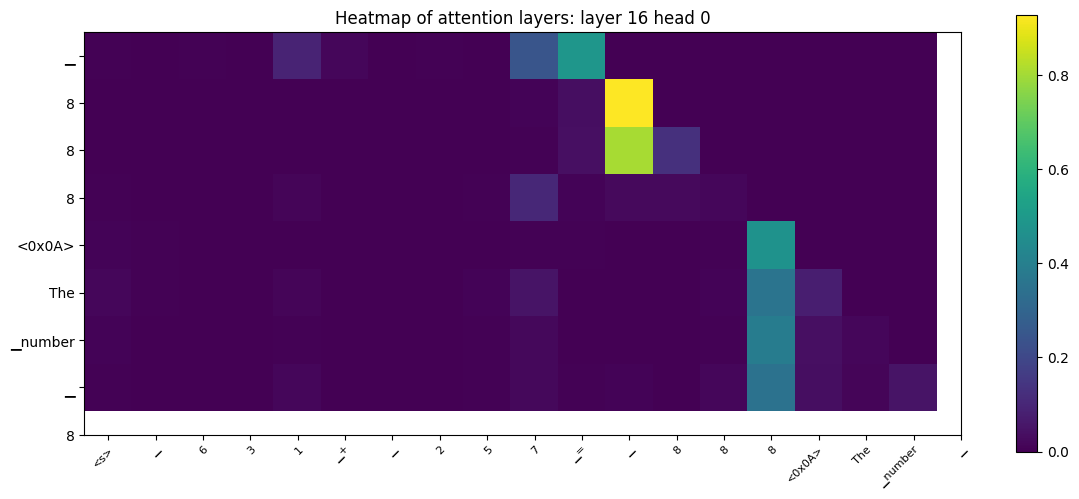

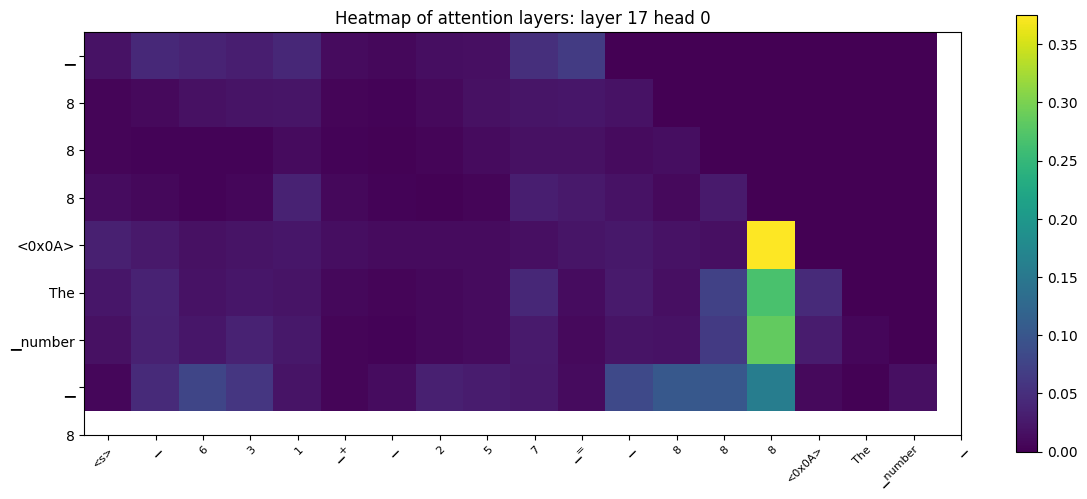

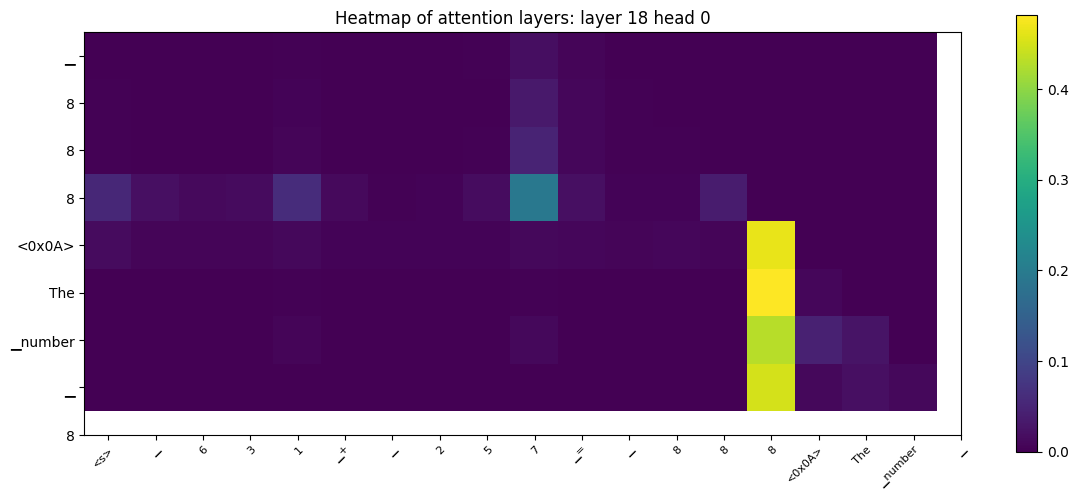

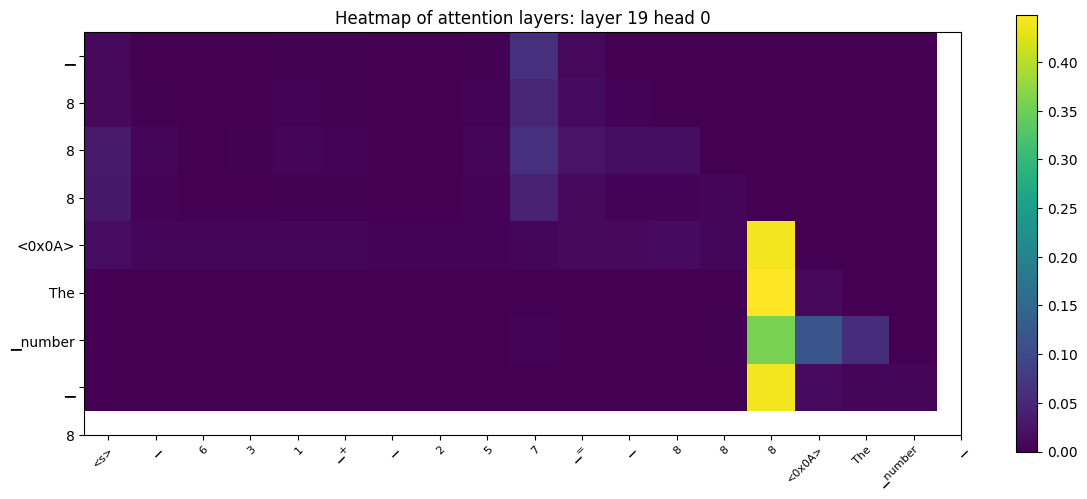

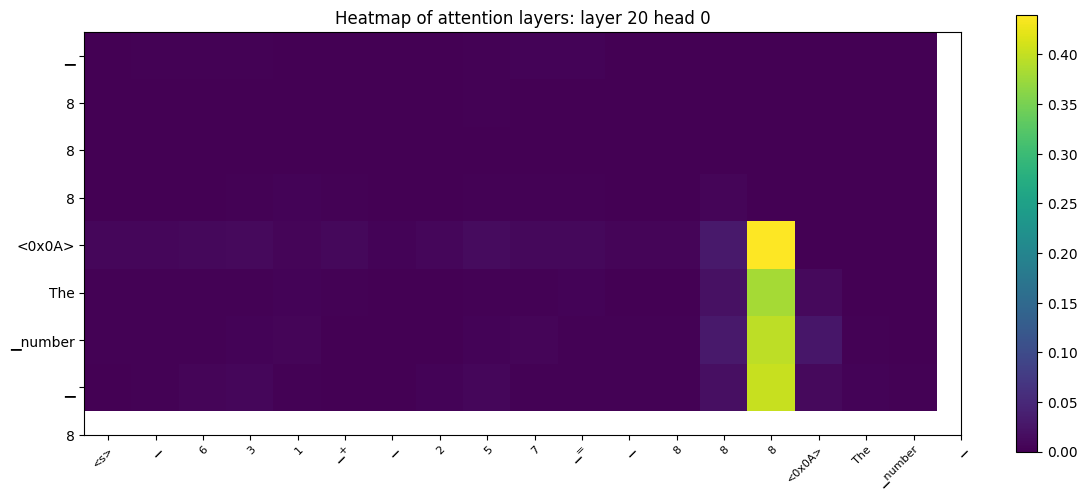

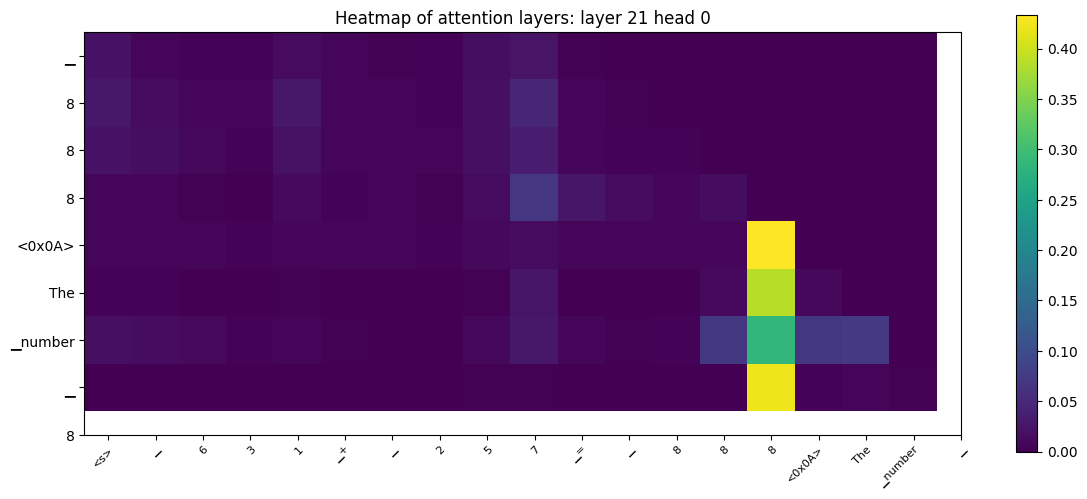

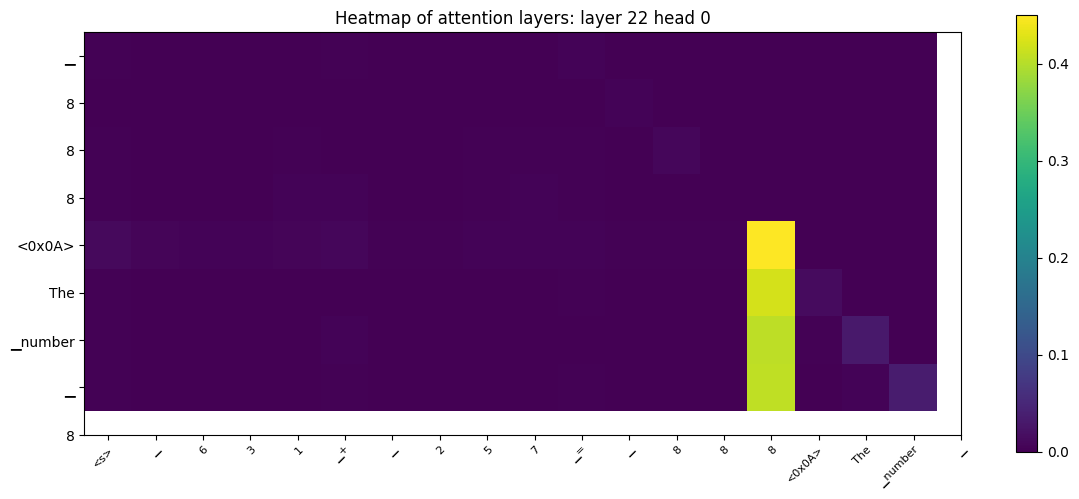

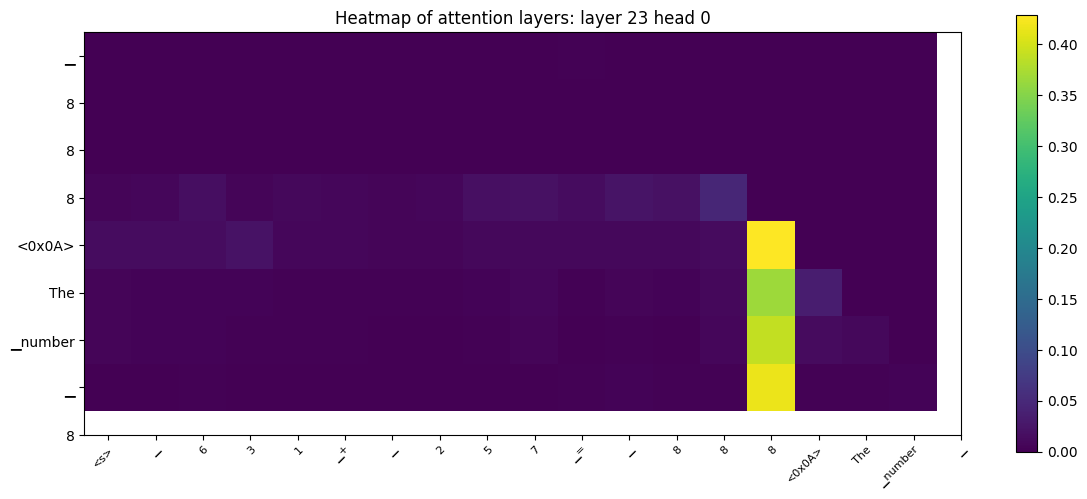

In [24]:
### ALTERATION ### Edited generated_tokens and plot_attentions(..., past_tokens) tu include starting tokens
input_tokens = tokenizer.convert_ids_to_tokens(generated_output.sequences[0])
print(len(input_tokens))
generated_tokens = input_tokens[input_len:]
past_tokens = input_tokens[0:-1]
print(len(generated_tokens))
print(len(past_tokens))
for layer in range(0, 24):
    #for head in range(0, 32):
    head = 0
    plot_attentions(generated_output, layer, head, generated_tokens, past_tokens[0:])

In [25]:
print(f"Total length of sequence is : {generated_output.sequences.shape}")
print(f"Length of input sequence is: {inputs.input_ids.shape}")
print(f"We have therefore: {len(generated_output.hidden_states)} tokens with hidden states")
#print(f"We have therefore: {len(generated_output.scores)} tokens with scores")
#print(f"We have therefore: {len(generated_output.attentions)} tokens with attentions layers")
print()
print(f"Each token has : {len(generated_output.hidden_states[0])} hidden states")
#print(f"Each token has : {len(generated_output.scores[0])} scores")
#print(f"Each token has : {len(generated_output.attentions[0])} attention layers")
print()
print(f"Each hidden state has dimensions {generated_output.hidden_states[0][0].shape} and {generated_output.hidden_states[-1][0].shape}")
#print(f"Each score has dimensions {generated_output.scores[0][0].shape}")
#print(f"Each attention layer has dimensions from {generated_output.attentions[0][0].shape} to {generated_output.attentions[-1][0].shape}")

Total length of sequence is : torch.Size([1, 20])
Length of input sequence is: torch.Size([1, 11])
We have therefore: 9 tokens with hidden states

Each token has : 33 hidden states

Each hidden state has dimensions torch.Size([1, 11, 4096]) and torch.Size([1, 1, 4096])


In [26]:
# Output Representations
### ALTERATION ### Added column renaming
predictions = embed_hidden_states(model, generated_output.hidden_states, "output", include_prompt=True)
rows = [tokenizer.convert_ids_to_tokens(pred) for pred in predictions]
df_out = pd.DataFrame(rows).T.sort_index(ascending=False).rename(columns={n: col for n, col in enumerate(past_tokens + generated_tokens)})
df_out = fix_dataframe_characters(df_out, [("Ġ", "␣"), ("Ċ", "\n")], columns=True)

/tmp/ipykernel_33/4122611728.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace(old, new))


In [ ]:
df_out

In [27]:
# Input Representations
### ALTERATION ### Added column renaming
predictions = embed_hidden_states(model, generated_output.hidden_states, "input", include_prompt=True)
rows = [tokenizer.convert_ids_to_tokens(pred) for pred in predictions]
df_in = pd.DataFrame(rows).T.sort_index(ascending=False).rename(columns={n: col for n, col in enumerate(past_tokens + generated_tokens)})
df_in = fix_dataframe_characters(df_in, [("Ġ", "␣"), ("Ċ", "\n")], columns=True)

/tmp/ipykernel_33/4122611728.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace(old, new))


In [ ]:
df_in

In [28]:
def create_transformer_plot(dfs, generated_output, exclude=[], heads=range(0, 1), threshold=0.002, permanent_threshold=0.4, default_emb="output", default_head=0):

    nodes = {key: [] for key in dfs.keys()}
    edges = {head: [] for head in heads}
    permanent_edges = {head: [] for head in heads}
    line_hover_traces = {head: [] for head in heads}
    permanent_line_hover_traces = {head: [] for head in heads}
    
    for key, df in dfs.items():
        
        nodexs = []
        nodeys = []

        # Cycle through every layer of the model, gathering all blocks as nodes
        for idx, row in df.iterrows():

                # Generate coordinates for nodes
                xs = [i for i in range(len(row))]
                ys = [idx] * len(row)

                nodexs.append(xs)
                nodeys.append(ys)

                for x, y in zip(xs, ys):

                    color = "lightblue"
                    if x in exclude:
                        color = "red"

                    # Create nodes
                    nodes[key].append(go.Scattergl(
                        x=[x],
                        y=[y],
                        name="node",
                        mode="markers+text",
                        marker=dict(size=20, color=color),
                        marker_line_width=2,
                        marker_symbol=1,
                        text=row[x],
                        textposition="bottom center",
                        hoverinfo="none",
                        customdata=[{"type":"node"}],
                        showlegend=False
                    ))

    for head in heads:
        # Cycle through every layer of the model, gathering the aggregated coordinates for each node in a layer
        for idx, coords in enumerate(zip(nodexs, nodeys)):
            xs, ys = coords

            # Do not plot attention traces for the starting layer
            if idx != 0:
                # Compute the attention weights for the current layer and head
                attentions = compute_complete_padded_attentions(generated_output, layer=idx-1, head=head)

                # Cycle through every node in the layer, gathering its coordinates 
                for i, c in enumerate(zip(xs, ys)):
                    x, y = c

                    # Cycle through every node in the PREVIOUS layer w.r.t. the current one, gathering its coordinates 
                    for ii, cc in enumerate(zip(nodexs[idx - 1], nodeys[idx - 1])):
                        xx, yy = cc
                        weight = attentions[ii][i]
                        
                        if x not in exclude and weight >= threshold:
                            if weight >= permanent_threshold:
                                # Create single edge representing the attention weigth
                                permanent_edges[head].append(go.Scattergl(
                                    x=[x, xx],
                                    y=[y, yy],
                                    name="pedge",
                                    mode="lines",
                                    hoverinfo="none",
                                    line=dict(color="rgba(125,125,125,0.8)", width=2 * weight + 0.25),
                                    customdata=[{"type": "edge"}],
                                    showlegend=False,
                                ))

                                # Create all hidden hoverable nodes displaying the attention weight values
                                permanent_line_hover_traces[head].append(go.Scattergl(
                                    x=[(x+xx)/2],
                                    y=[(y+yy)/2],
                                    name="ptrace",
                                    text=f"{str(weight)}",
                                    mode='markers',
                                    hoverinfo='text',
                                    opacity=0,
                                    customdata=[{"type": "hover_trace", "P1": {"x": x, "y": y}, "P2": {"x": xx, "y":yy}}],
                                    showlegend=False,
                                ))
                            else:
                                # Create single edge representing the attention weigth
                                edges[head].append(go.Scattergl(
                                    x=[x, xx],
                                    y=[y, yy],
                                    name="edge",
                                    mode="lines",
                                    hoverinfo="none",
                                    line=dict(color="rgba(125,125,125,0.8)", width=2 * weight + 0.25),
                                    customdata=[{"type": "edge"}],
                                    showlegend=False,
                                ))

                                # Create all hidden hoverable nodes displaying the attention weight values
                                line_hover_traces[head].append(go.Scattergl(
                                    x=[(x+xx)/2],
                                    y=[(y+yy)/2],
                                    name="trace",
                                    text=f"{str(weight)}",
                                    mode='markers',
                                    hoverinfo='text',
                                    opacity=0,
                                    customdata=[{"type": "hover_trace", "P1": {"x": x, "y": y}, "P2": {"x": xx, "y":yy}}],
                                    showlegend=False,
                                ))

    # Create figure
    # fig = go.Figure(data=nodes + edges + line_hover_traces)
    fig = go.Figure(data=nodes[default_emb] + permanent_edges[default_head] + permanent_line_hover_traces[default_head])

    # Customize layout
    fig.update_layout(
        title="Transformer Weights Visualization",
        showlegend=True,
        xaxis=dict(showticklabels=False, zeroline=False),
        yaxis=dict(showticklabels=False, zeroline=False),
        plot_bgcolor='white',
        width=1600, height=1500,
        uirevision="const"
    )
    
    return fig, nodes, (edges, permanent_edges), (line_hover_traces, permanent_line_hover_traces)

In [29]:
heads = range(0, 3)
figure, nodes, edges, hover_traces = create_transformer_plot({"input": df_in, "output": df_out}, generated_output, exclude=[0], heads=heads)

edges, permanent_edges = edges
hover_traces, permanent_hover_traces = hover_traces
permanent_traces = {head: {"edges": permanent_edges[head], "hovers": permanent_hover_traces[head]} for head in heads}

fig = go.FigureWidget(figure)

fig.show()

/tmp/ipykernel_33/3275170935.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text=row[x],


In [30]:
def compute_edge_cache(nodes, edges, hover_traces, heads=range(0,1)):
    return {
        (x,y):  { 
            head: {
                "edges": [edge for edge in edges[head] if (edge.x[1] == x and edge.y[1] == y) or (edge.x[0] == x and edge.y[0] == y)],
                "hovers": [trace for trace in hover_traces[head] if (trace.customdata[0]["P1"]["x"] == x and trace.customdata[0]["P1"]["y"] == y) or (trace.customdata[0]["P2"]["x"] == x and trace.customdata[0]["P2"]["y"] == y)]
            } for head in heads
        }
        for x, y in [(x,y) for node_coords in [zip(node_batch.x, node_batch.y) for node_batch in nodes] for x,y in node_coords]
    }

In [31]:
edge_cache = compute_edge_cache(list(nodes.values())[0], edges, hover_traces, heads)

In [32]:
import ngrok
import asyncio
import dash

from dash import dcc, html, ctx, Patch
from dash.dependencies import Input, Output, State

import plotly.graph_objects as go

In [33]:
async def deploy_ngrok(address="http://127.0.0.1:8050"):
    listener = ngrok.forward(addr=address, authtoken=UserSecretsClient().get_secret("ngrok_key"))
    await asyncio.wait_for(listener, timeout=10)
    public_url = listener.result().url()
    print(f"Deploy URL: {public_url}")
    return listener.result()

In [34]:
app = dash.Dash("Test")

# Define the layout of the app
app.layout = html.Div([
    html.P(children="Attention Head Selector"),
    dcc.Slider(min(heads), max(heads), 1, value=0, id='attention_heads'),
    html.P(children="Embeddings Selector"),
    dcc.RadioItems(['input', 'output'], value='output', inline=True, id='embeddings'),
    dcc.Graph(id='scatterplot', figure=fig),
])

# Define callback to update scatter plot
@app.callback(
    Output('scatterplot', 'figure'),
    [Input('scatterplot', 'hoverData'), Input('attention_heads', 'value'), Input('embeddings', 'value')],
    State('scatterplot', 'figure')
)
def update_scatter_plot(hover_data, attention_head, embeddings, figure):
    if ctx.triggered_prop_ids:
        p = Patch()
        # Update for hovering over a plot node
        if "scatterplot.hoverData" in ctx.triggered_prop_ids and hover_data and "customdata" in hover_data["points"][0] and hover_data["points"][0]["customdata"]["type"] == "node":
            x = hover_data['points'][0]['x']
            y = hover_data['points'][0]['y']
            _ = [p["data"].remove(el) for el in [f for f in figure["data"] if f["name"] not in ["pedge", "ptrace", "node"]]]
            add_traces = edge_cache[(x, y)][attention_head]["edges"] + edge_cache[(x, y)][attention_head]["hovers"]
        # Update for changing attention head visualization
        elif "attention_heads.value" in ctx.triggered_prop_ids:
            _ = [p["data"].remove(el) for el in [f for f in figure["data"] if f["name"] not in ["node"]]]
            add_traces = permanent_traces[attention_head]["edges"] + permanent_traces[attention_head]["hovers"]
        # Update for changing embeddings visualization
        elif "embeddings.value" in ctx.triggered_prop_ids:
            _ = [p["data"].remove(el) for el in [f for f in figure["data"] if f["name"] not in ["ptrace"]]]
            add_traces = nodes[embeddings] + permanent_traces[attention_head]["edges"]
        else:
            return p
        p["data"].extend(add_traces)
        return p
    return figure

In [35]:
# Run the app
if __name__ == '__main__':
    app.run(debug=True, jupyter_mode="_none")

In [37]:
await deploy_ngrok()

Deploy URL: https://dc89-34-90-56-91.ngrok-free.app
